# Table of Contents:

1. [Data Understanding](#1.-Data-Understanding)
2. [Feature Importance](#2.-Feature-Importance)
3. [Outlier Detection](#3.-Outlier-Detection)
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Model Building and Evaluation](#5.-Model-Building-and-Evaluation)
6. [Results](#6.-Results)
7. [Conclusion](#7.-Conclusion)

## 1. Data Understanding

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score,classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.model_selection import RandomizedSearchCV
# import shap

### 1.1 Load Data


In [2]:
data_path = 'data/DealData.xlsx'
data = pd.read_excel(data_path)

In [3]:
print('Data Shape: ', data.shape)
print('Data Columns: ', data.columns)

Data Shape:  (140000, 32)
Data Columns:  Index(['MONTH', 'YEAR', 'PROMOTIONTYPE', 'ACCOUNTSTATUS', 'ACCOUNTTYPE',
       'ROUTETOMARKETTYPE', 'SOURCETYPE', 'SOURCE', 'CURRENTSTAGE', 'WINLOSS',
       'SUBSCRIPTIONPERIODTYPE', 'CONVERSIONTMEBAND', 'SUBSCRIPTIONSIZEBAND',
       'INTERACTIONTYPE', 'INTERACTIONLEVELBAND', 'SALESTEAMSCORE',
       'ACCOUNTNEED', 'SEGMENTCONDITION', 'MARKETCONDITION', 'PRODUCTGAPLEVEL',
       'LIFETIMESPENDBAND', 'DEALSIZEBAND', 'CONFIDENCELEVELBAND',
       'CUSTOMERSEGMENT', 'REGION', 'BUSINESSUNIT', 'PRODUCTCLASS',
       'SALESREGION', 'SALESTEAM', 'DISCOUNTvARIANCE', 'IDSCOUNTVARBAND',
       'DISCOUNTBAND'],
      dtype='object')


The data contains 140000 rows and 32 columns with the columns. Let us load the data and check the first few rows.

In [4]:
data.head()

,MONTH,YEAR,PROMOTIONTYPE,ACCOUNTSTATUS,ACCOUNTTYPE,ROUTETOMARKETTYPE,SOURCETYPE,SOURCE,CURRENTSTAGE,WINLOSS,...,CONFIDENCELEVELBAND,CUSTOMERSEGMENT,REGION,BUSINESSUNIT,PRODUCTCLASS,SALESREGION,SALESTEAM,DISCOUNTvARIANCE,IDSCOUNTVARBAND,DISCOUNTBAND
0,6,2023,1,3,1,3,6,5,4,0,...,2,7,6,4,9,4,7,3.05,2,4
1,1,2024,10,1,3,2,5,8,4,0,...,2,8,8,3,6,5,10,0.34,1,1
2,5,2021,8,3,3,1,6,3,4,0,...,1,4,4,4,10,3,6,10.82,3,6
3,9,2020,1,2,3,1,4,10,4,0,...,3,3,5,3,6,3,5,5.38,2,4
4,4,2022,7,1,2,3,4,6,4,0,...,4,9,2,2,3,5,9,-6.38,-2,6


From Deal Data Description, we can understand the different columns in the data.
There are three target variables in the data. They are:


### 1.2 Data Checks
- Check for missing values
- Check for duplicate rows
- Check for number of unique values in each column
- Check for data types
- Check for statistical summary

In [5]:
# Checking for null values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186741 entries, 0 to 186740
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   col_0   186741 non-null  float64
 1   col_1   186741 non-null  float64
 2   col_2   186741 non-null  float64
 3   col_3   186740 non-null  float64
 4   col_4   186740 non-null  float64
 5   col_5   186740 non-null  float64
 6   col_6   186740 non-null  float64
 7   col_7   186740 non-null  float64
 8   col_8   186740 non-null  float64
 9   col_9   186740 non-null  float64
 10  col_10  186740 non-null  float64
 11  col_11  186740 non-null  float64
 12  col_12  186740 non-null  float64
 13  col_13  186740 non-null  float64
 14  label   186740 non-null  float64
dtypes: float64(15)
memory usage: 21.4 MB


In [6]:
# Delete any NaN values, alternatively they can be imputed
data.dropna(inplace=True)


In [7]:
# Check for duplicate rows
data.duplicated().sum()

24

In [8]:
# Removing duplicate rows
data.drop_duplicates(inplace=True)

In [9]:
# Check for unique values in each column
data.nunique()

col_0     186435
col_1          2
col_2      48484
col_3          3
col_4      53716
col_5     182705
col_6      79096
col_7     134888
col_8     138350
col_9      41908
col_10       701
col_11     57130
col_12     37348
col_13      4666
label          2
dtype: int64

In [10]:
data.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,label
count,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000,186716.000000
mean,0.795168,0.109476,0.903156,0.179781,0.206851,0.779570,0.703592,0.882341,0.873218,0.880573,57.684724,0.775027,0.710149,0.911193,0.747054
std,0.084887,0.312237,0.077777,0.365216,0.296019,0.126074,0.238043,0.073257,0.168756,0.156379,64.918223,0.190022,0.243353,0.239132,0.434701
min,-0.050092,0.000000,0.427709,0.000000,-0.034262,-0.079069,-0.087866,0.128208,0.000000,-0.152368,0.000000,0.000000,0.034793,0.000000,0.000000
25%,0.749892,0.000000,0.863930,0.000000,0.000000,0.708877,0.510391,0.852954,0.862537,0.795812,19.000000,0.705655,0.503555,1.000000,0.000000
50%,0.806148,0.000000,0.919872,0.000000,0.000000,0.794577,0.693529,0.901734,0.917203,0.976567,41.000000,0.813726,0.701206,1.000000,1.000000
75%,0.853576,0.000000,0.960903,0.000000,0.462922,0.868399,1.000000,0.932031,0.947119,0.998546,72.000000,0.899600,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992529,0.994214,0.999511,2616.000000,1.000000,1.000000,1.000000,1.000000


Obesevations:
- There are no missing values in the data.
- The data types of the columns are all float, except for the label column which is int.
- There are 74 duplicate rows in the data. These are removed from the data.
- col_0, col_4, col_5, col_6, col_9, col_10 and col_12 contain negative values. The other columns contain only positive values.
- The means of all columns except col_10 are close to 0 and the standard deviations are close to 1. The mean of col_10 is 58.64 and the standard deviation is 67.47. This could indicate that the col_10 column is not scaled while the other columns are scaled.

### 1.3 Data Visualization and EDA: Exploratory Data Analysis

array([[<Axes: title={'center': 'col_0'}>,
        <Axes: title={'center': 'col_1'}>,
        <Axes: title={'center': 'col_2'}>,
        <Axes: title={'center': 'col_3'}>],
       [<Axes: title={'center': 'col_4'}>,
        <Axes: title={'center': 'col_5'}>,
        <Axes: title={'center': 'col_6'}>,
        <Axes: title={'center': 'col_7'}>],
       [<Axes: title={'center': 'col_8'}>,
        <Axes: title={'center': 'col_9'}>,
        <Axes: title={'center': 'col_10'}>,
        <Axes: title={'center': 'col_11'}>],
       [<Axes: title={'center': 'col_12'}>,
        <Axes: title={'center': 'col_13'}>,
        <Axes: title={'center': 'label'}>, <Axes: >]], dtype=object)

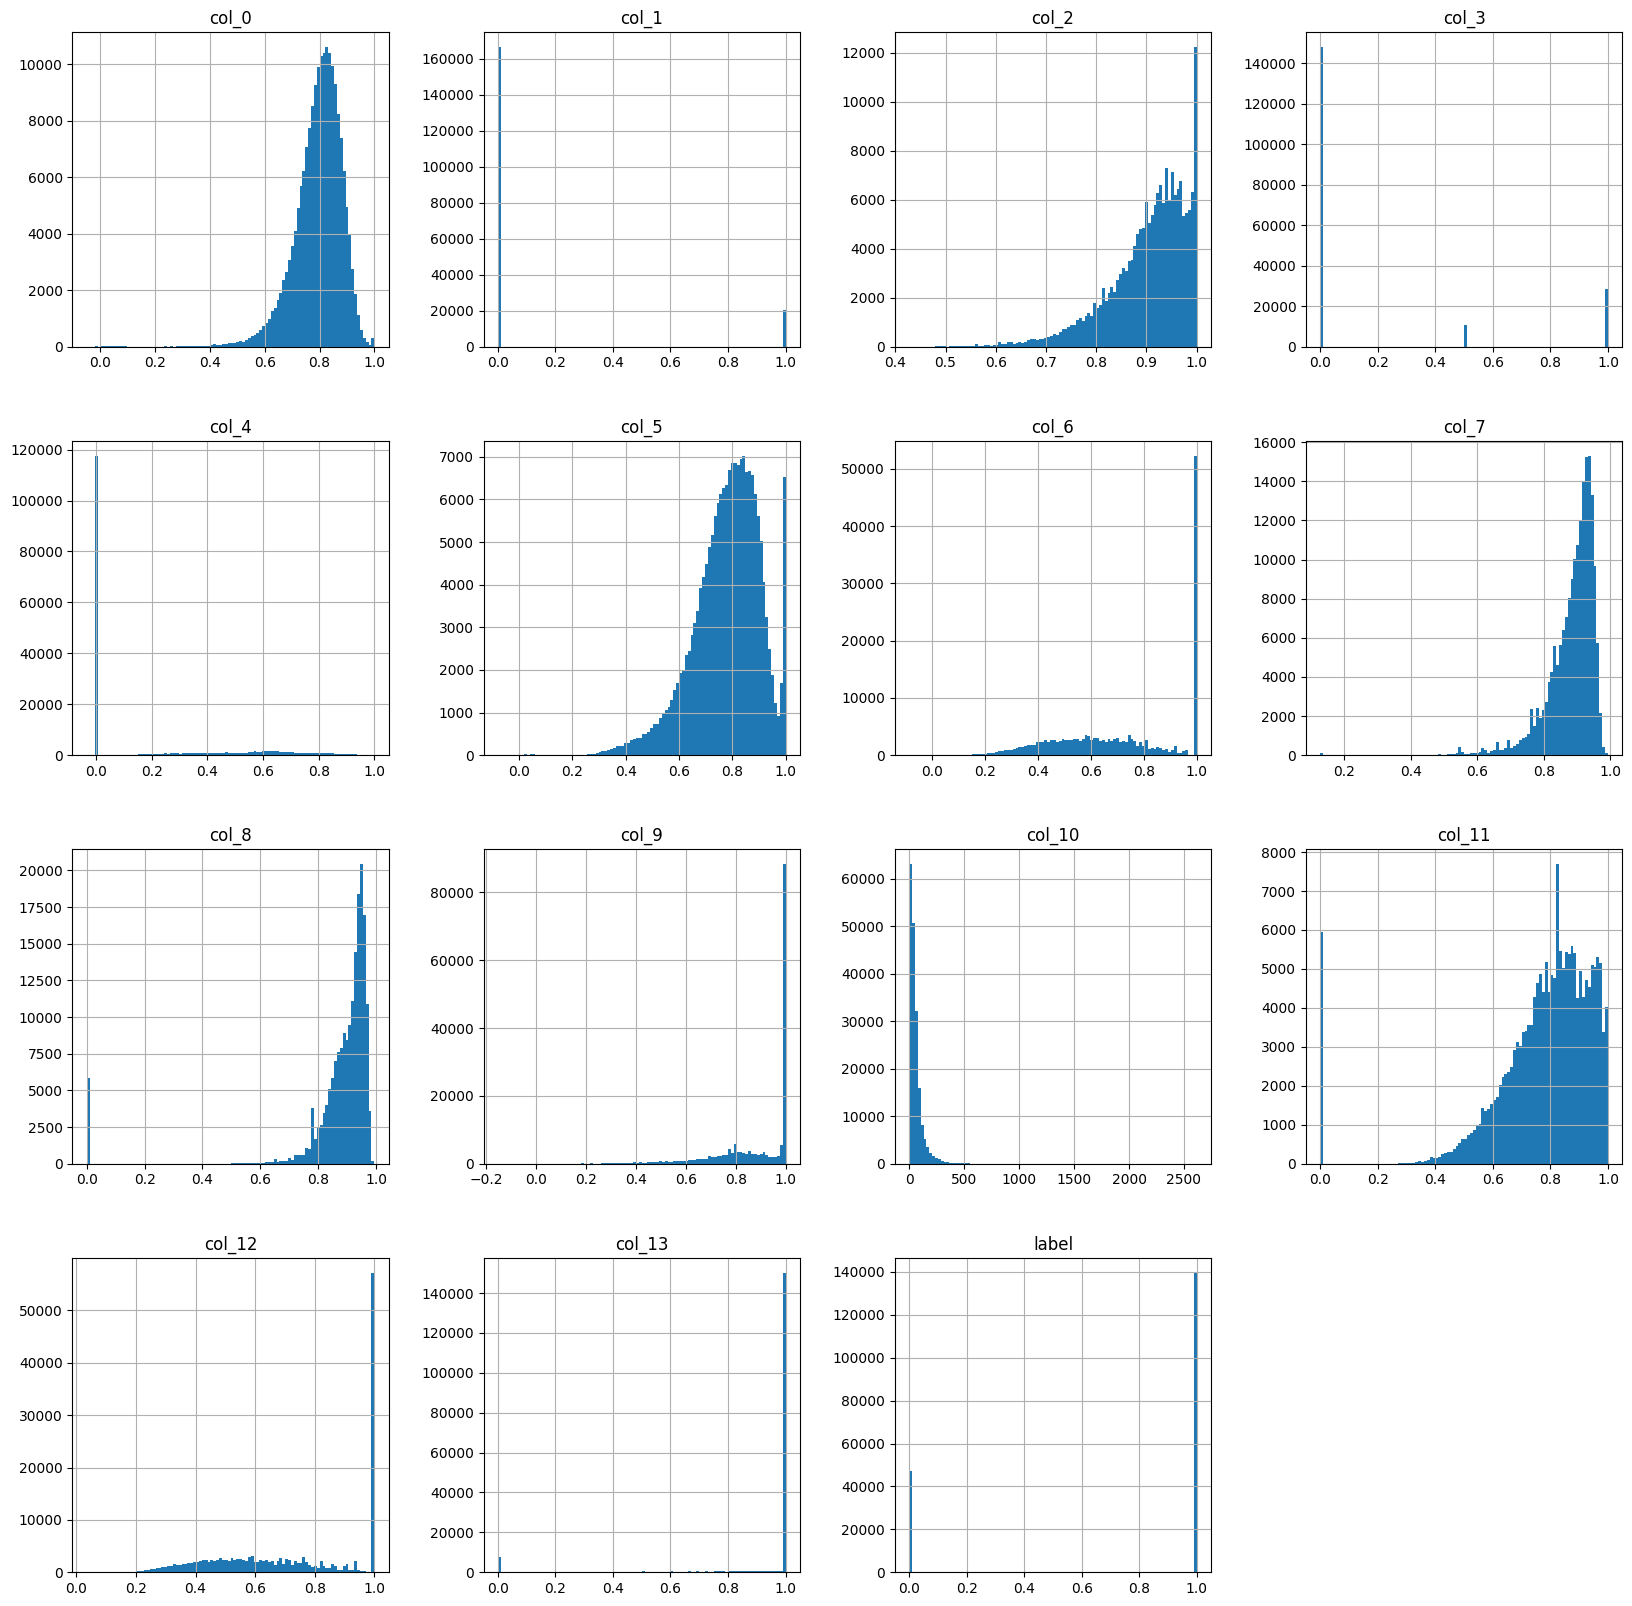

In [11]:
data.hist(figsize=(20, 20), bins=100)

col_1, col_3 and label columns seem to be categorical columns. Let us check the unique values in these columns.

In [12]:
print(data['col_1'].unique())
print(data['col_3'].unique())
print(data['label'].unique())

[1. 0.]
[0.  0.5 1. ]
[1. 0.]


In [13]:
data['col_13'].value_counts()

1.000000    149710
0.000000      7641
0.500000       668
0.666667       419
0.750000       321
             ...  
0.906404         1
0.900826         1
0.662722         1
0.715517         1
0.636605         1
Name: col_13, Length: 4666, dtype: int64

In [14]:
data['label'].value_counts(normalize=True)

1.0    0.747054
0.0    0.252946
Name: label, dtype: float64

In [15]:
# Check the skewness of each column and identify the columns that are skewed
data.skew()

col_0    -1.179027
col_1     2.501484
col_2    -1.220946
col_3     1.661063
col_4     0.992811
col_5    -0.826860
col_6    -0.140884
col_7    -2.337513
col_8    -4.355452
col_9    -1.505985
col_10    4.032618
col_11   -2.182947
col_12   -0.150195
col_13   -2.942393
label    -1.136675
dtype: float64

Observations:

- It can be concluded that these col_1, col_3 and label columns are categorical columns. 
- The col_1 column has 2 unique values (0,1), col_3 column has 3 unique values (0,0.5,1) and the label column has 2 unique values(0,1).
- While col_13 seemed to be a categorical column, it is not.
- The label column is balanced with about 50% of the data belonging to each class.
- It can be observed that most columns are skewed. Thus we will need to scale the data before building the model.
- There are many outliers and sudden spikes in the data. These need be analysed further.

We can confirm that the data is balanced.

 Let us check the skewness of each column. 

In [16]:
# Setting numerical and categorical columns
caltegorical_cols = ['col_1', 'col_3']
numerical_cols = ['col_2', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13']

Checking via KDE plot

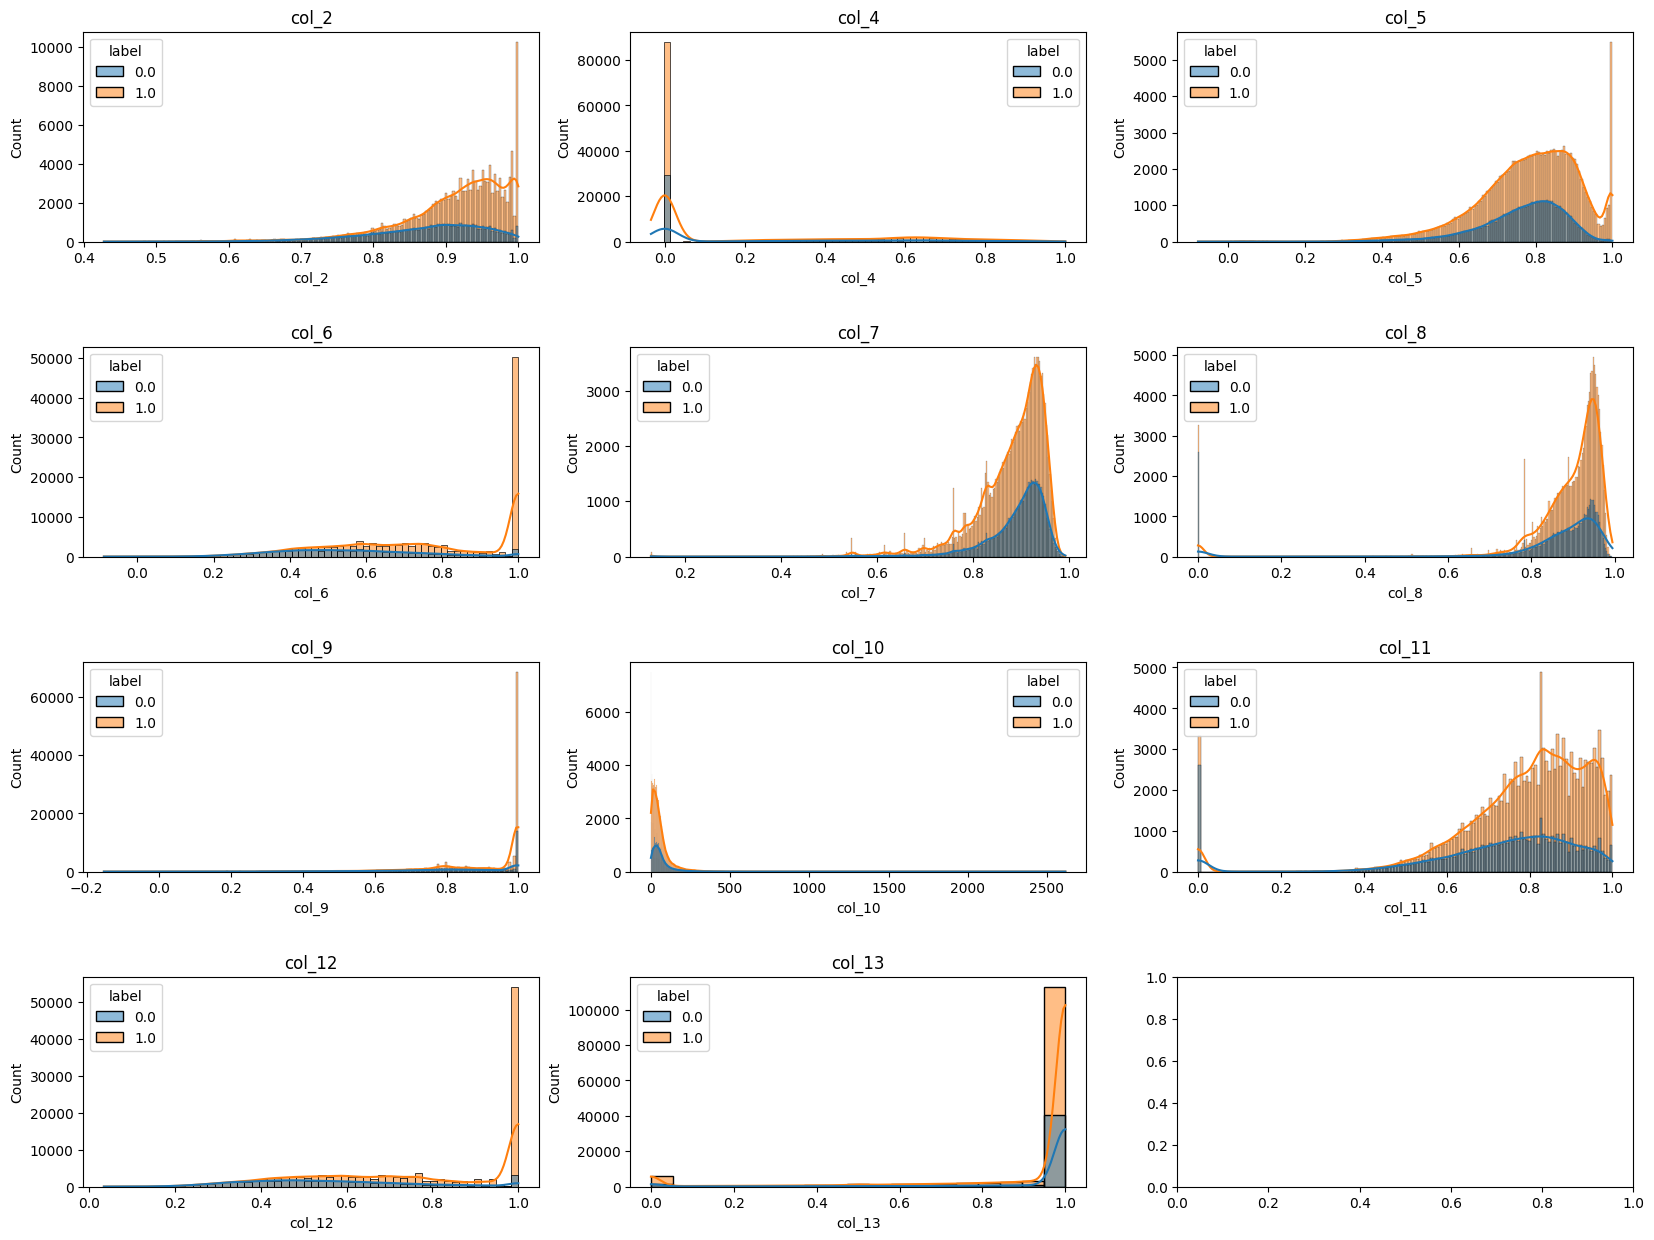

In [17]:
# Plotting the distribution of each numerical column with respect to the target variable, plot them all in subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
for i, col in enumerate(numerical_cols):
    sns.histplot(data=data, x=col, hue='label', ax=axes[i//3, i%3], kde=True)
    axes[i//3, i%3].set_title(col)
plt.show()

Observations:
- For col_1, Label 1 has higher value distribution than Label 0

# 2. Feature Importance

Feature importance is a technique used to select features in a dataset. It helps us to identify the features which are more important than the others in predicting the target variable. 
The most basic check for feature importance is to check the correlation of each feature with the target variable. The features with higher correlation are more important than the others.

### 2.1 Correlation Analysis

<Axes: >

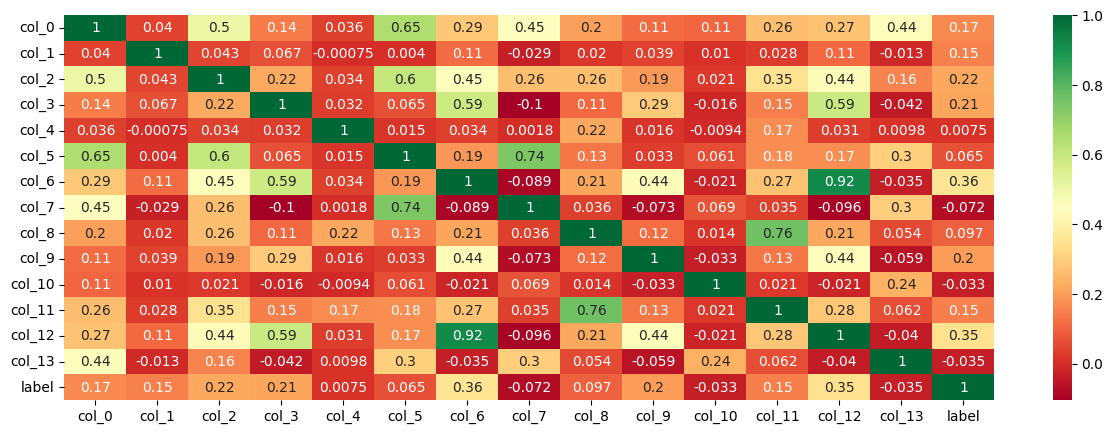

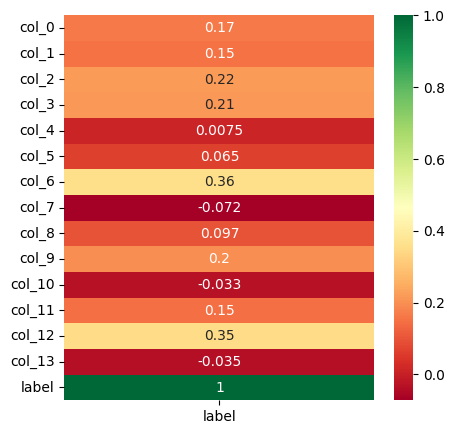

In [18]:
# Check the correlation between the columnsas a heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')

# Check the correlation between the columns and the label as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(data.corr()[['label']], annot=True, cmap='RdYlGn')

We perform correlation analysis to check the correlation between the features and the label and visualize the correlation using a heatmap.
Closer the color to green (1), higher the correlation. Closer the color to red (0), lower the correlation.

Observations:
- col_12 and col_6 have the highest correlation with the label.
- col_7, col_10 and cpl_13 have a negative correlation with the label. This means that as the value of these columns increase, the label value decreases.

In [19]:
# Features in order of importance
data.corr()['label'].sort_values(ascending=False)

label     1.000000
col_6     0.356520
col_12    0.347104
col_2     0.217077
col_3     0.212998
col_9     0.197749
col_0     0.165274
col_1     0.151264
col_11    0.147036
col_8     0.096827
col_5     0.064634
col_4     0.007469
col_10   -0.033412
col_13   -0.034739
col_7    -0.072254
Name: label, dtype: float64

Furthermore, feature importance can be also be checked using the following techniques:
- Univariate Selection
- Feature Importance using ExtraTreesClassifier
- Feature Importance using SelectKBest

These methods involve fitting the model and then checking the feature importance.

# 3. Outlier Detection

Before we proceed with outlier detection, the data needs to be split into train and test sets. 

This is done to avoid data leakage. Data leakage occurs when information from outside the training dataset is used to create the model leading to overfitting of the model.

Outlier detection is done on the train set.

It is  important to note that the outliers should be removed only from the train set and not from the entire dataset. This is because the test set is a representation of the real world data and the real world data will also contain outliers. Thus, the model should be trained on data that is similar to the real world data.

Another important point to note is that the outliers should be removed before scaling the data. This is because the outliers will affect the mean and standard deviation of the data and thus affect the scaling.

### 3.1 Split Data

Proceeding with a 80:20 split of the data into train and test sets.

The higher train split is chosen as we have about 56000 rows of data for testing after the split. This is sufficient to test the model.

Additionally, we will use stratified sampling to split the data. This is done to ensure that the train and test sets have the same proportion of the label column.


In [20]:
X, y = data.drop('label', axis=1), data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['label'])

### 3.2 Detection techniques

Outliers are data points that are significantly different from the other data points in the dataset. Outliers can be detected using the following methods:
- Boxplot
- Z-Score
- IQR Score

#### 3.2.1 Boxplot

In a boxplot, the outliers are the points that lie outside the whiskers of the boxplot. The points outside the upper whisker are the upper outliers and the points outside the lower whisker are the lower outliers.

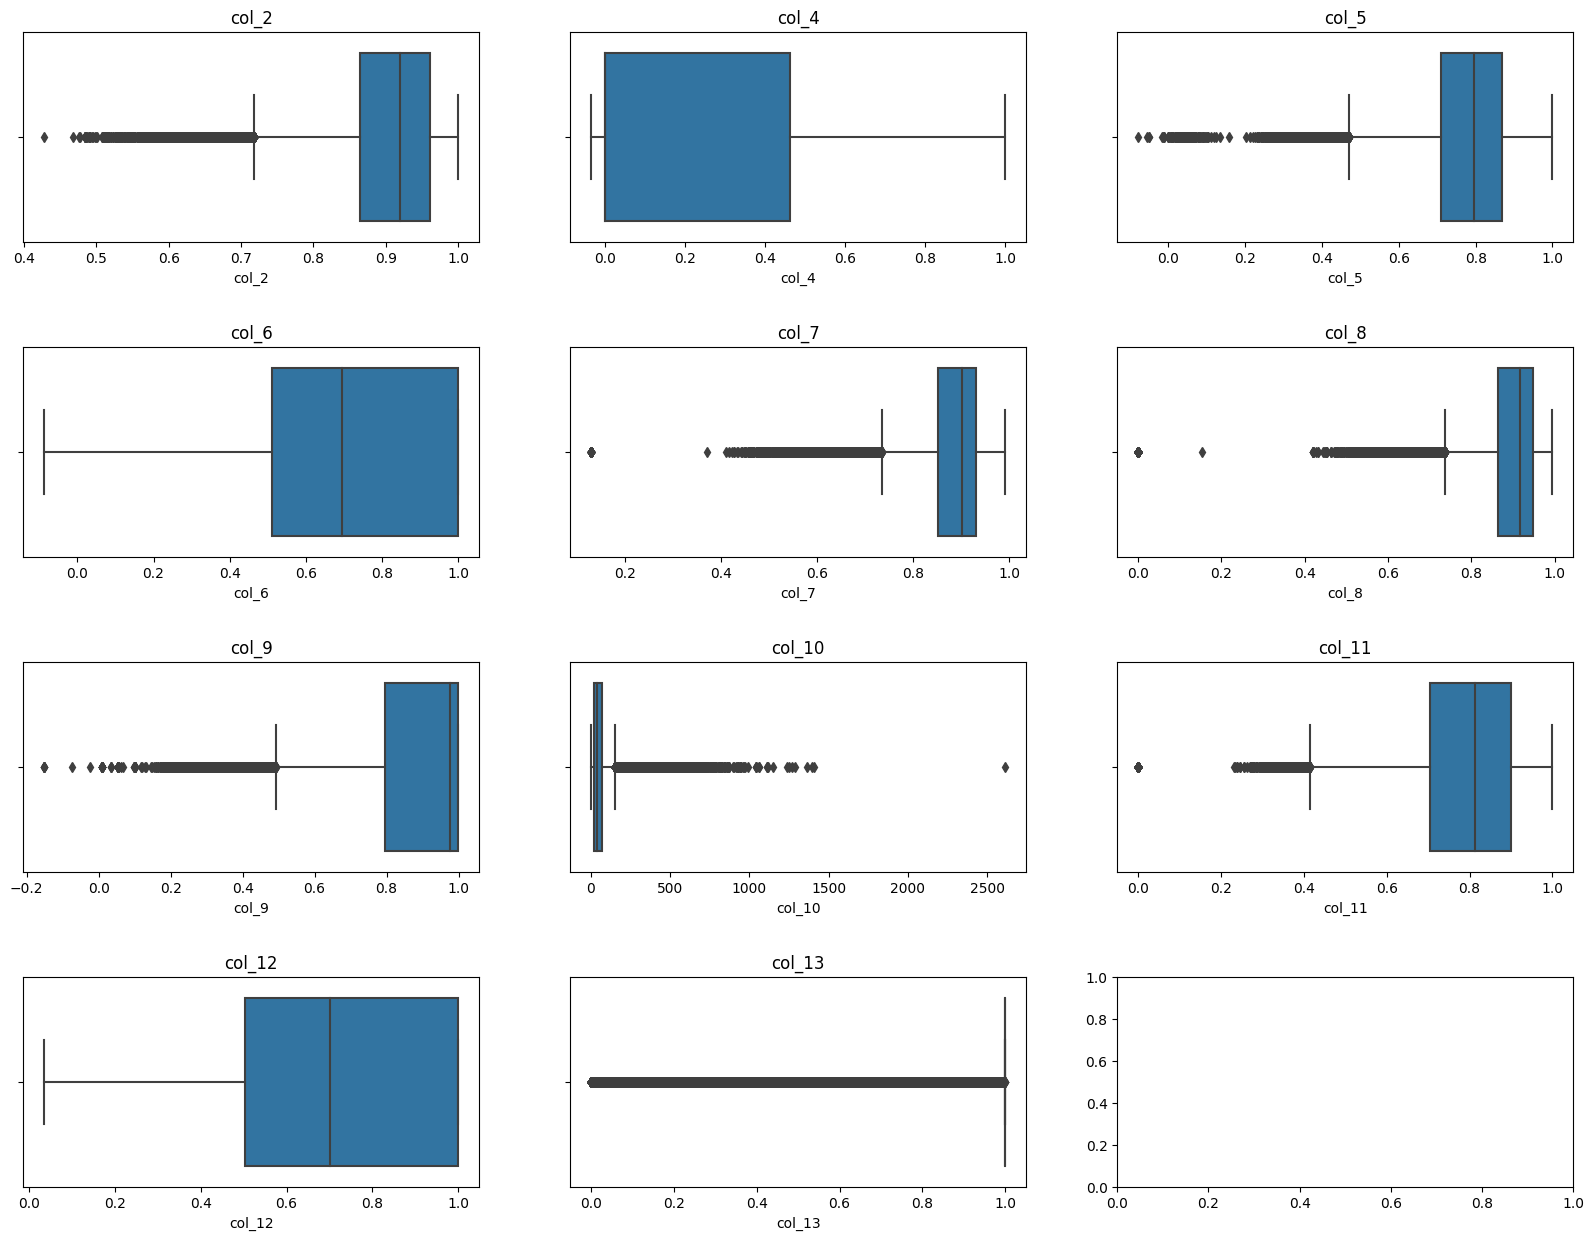

In [21]:
# Plot the boxplot of each numerical column with outliers
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=data, x=col, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(col)
plt.show()

#### 3.2.2 Z-Score

Z-Score is the number of standard deviations a data point is away from the mean. The data points with a z-score greater than 3 or less than -3 are considered as outliers.

In [22]:
# Compute and plot the z-score
z = np.abs(stats.zscore(data[numerical_cols]))
# Print the outliers
print(np.where(z > 3))

(array([     4,      4,     12, ..., 186694, 186694, 186711]), array([ 4, 10, 10, ...,  4, 10,  7]))


#### 3.2.3 IQR Score

IQR Score is the difference between the 75th and 25th percentile of the data. The data points with an IQR score greater than 1.5 times the IQR score are considered as outliers.

In [23]:
# Compute and plot the IQR
Q1 = data[numerical_cols].quantile(0.25)
Q3 = data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
# Print the outliers
print(np.where((data[numerical_cols] < (Q1 - 1.5 * IQR)) | (data[numerical_cols] > (Q3 + 1.5 * IQR))))

(array([     2,      4,      4, ..., 186704, 186704, 186711]), array([10,  4, 10, ...,  0, 10,  7]))


### 3.3 Outlier Handling

Not all outliers need to be removed. Outliers can be removed if they are due to errors in the data or if they are due to errors in the measurement. However, if the outliers are due to natural variation in the data, they should not be removed.
Some outliers can be removed if they are very few in number. However, if there are many outliers, they should not be removed as they may contain some information.

Some of the methods to handle outliers are:
- Removal: The outliers can be removed from the data.
- Capping: The outliers can be capped to the nearest value in the range.
- Imputation: The outliers can be imputed with the mean or median value of the column.

Since no information is available about the data, we cannot conclude whether the outliers are due to errors in the data or due to natural variation in the data. Thus, we will not remove the outliers.

# 4. Feature Engineering

Feature Engineering is the process of creating new features from the existing features in the data. This is done to improve the performance of the model.
Additionally, feature engineering can also be used to reduce the number of features in the data. This is done to reduce the complexity of the model and to reduce the training time of the model.

Apart from creating or reducing features, feature engineering can also be used to transform the data. This is done to make the data more suitable for the model.

- Since there is no information about the data, we will not be creating any new features.
- There are 14 features in the data. We can perform feature selection to reduce the number of features in the data.
- We will be transforming the data using the following techniques:
    - Scaling
    - Encoding

### NOTE: The data transformation and model building is done using pipelines. This is done to ensure that the test data is transformed in the same way as the train data.

### 4.0 Feature Selection

Feature selection is the process of selecting the most important features from the data. This is done to reduce the complexity of the model and to reduce the training time of the model.
Feature selection can be done using the following techniques:
- Statistical Methods: Chi-Square Test, ANOVA Test
- Feature Importance: ExtraTreesClassifier, SelectKBest
- Correlation Analysis
- Dimensionality Reduction: PCA
- Recursive Feature Elimination

We will be using Recursive Feature Elimination to select the most important features from the data using a Random Forest Classifier as the estimator.

In [24]:
### 4.1 Feature Selection
# Plot the feature importance
estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=10)

### 4.1 Scaling

Scaling is the process of transforming the data so that the data is in a similar range. 
- This is done to ensure that the data is not biased towards a particular feature. 
- Scaling helps in faster convergence of the model.
- Data should be scaled after splitting the data into train and test sets. This is done to avoid data leakage.
- Scaling is done on the train set and then the same scaling is applied to the test set.
- Scaling is not required for tree based models.
- Scaling is performed on numerical data only.

The following scaling techniques are used:
- StandardScaler: Used to standardize the data (Standardization is the process of transforming the data so that the mean is 0 and the standard deviation is 1).
- MinMaxScaler: Used to adjust the range of the data (The data is scaled to a range of 0 to 1).
- RobustScaler: Used to scale the data using the IQR score (The data is scaled using the IQR score so that the median is 0 and the IQR score is 1). Best suited for data with outliers.
- Log Transformation: Used to transform the data to correct skewness (The data is transformed using the log function).

*For our data, we will RobustScaler as the data contains outliers.*

In [25]:
# Create transformer for numerical columns to apply scaling
# Additionally, an imputer can be added to fill missing values using the median
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

### 4.2 Encoding

Categorical data cannot be used directly in the model. Thus, categorical data needs to be encoded into numerical data before it can be used in the model.

The following encoding techniques are used:
- Label Encoding: Used to encode the categorical data into numerical data. The categories are encoded with values ranging from 0 to n-1, where n is the number of categories.
- One Hot Encoding: Used to encode the categorical data into numerical data. The categories are encoded with binary values. A new column is created for each category and the value is 1 if the category is present and 0 if the category is not present.
- Ordinal Encoding: Used to encode the categorical data into numerical data. The categories are encoded with values ranging from 0 to n-1, where n is the number of categories. The categories are encoded in the order of their value.

One important aspect when choosing the encoding technique is the number of categories in the column. If the number of categories is high, then one hot encoding will lead to a large number of columns. This will increase the complexity of the model and increase the training time of the model. Thus one hot encoding should be used only if the number of categories is low.
Another aspect to consider in when the categories have an order. In such cases, ordinal encoding should be used. This is because one hot or label encoding will not preserve the order of the categories.

We have two categorical variables, 
- col_1 has values 0 and 1, this already represents a binary encoding, for consistency we will use ordinal encoding.
- col_3 has values 0, 0.5 and 1. This represents an ordinal encoding and thus ordinal encoding is used. 

We will use ordinal encoding for both the columns.

In [26]:
# Create a transformer for categorical columns to use label encoding
# Additionally, an imputer can be added to fill missing values using the most frequent value
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])


In [27]:
# Create a preprocessor to apply the transformers to the correct columns
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_cols),
    ('cat', cat_transformer, caltegorical_cols)
])

In [28]:
def train(classifier, X_train, y_train, X_test, y_test, param_space=None, pipe_display=True):

    pipe = Pipeline(steps=[
        # ('selector', selector),
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Display the pipeline as a graph
    if pipe_display:
        display(pipe)

    if param_space:
        opt = RandomizedSearchCV(pipe, param_space, n_iter=10, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

        # Fit the pipeline to the training data
        opt.fit(X_train, y_train)

        print(f"val. score: {opt.best_score_}")
        print("best params: ", opt.best_params_)
    else:
        opt = pipe

        # Fit the pipeline to the training data
        opt.fit(X_train, y_train)

    predictions = opt.predict(X_test)

    # Display classification report as a nicer table
    print(classification_report(y_test, predictions))


    # Plot ROC curve of the model
    RocCurveDisplay.from_predictions(y_test, predictions, name='ROC Curve')


    # Plot the confusion matrix of the model
    ConfusionMatrixDisplay.from_predictions(y_test, predictions)

    plt.show()

    # # Calculate the shap values and plot the summary plot
    # explainer = shap.Explainer(opt['classifier'])
    # shap_values = explainer(X_test)
    # shap.summary_plot(shap_values, X_test, plot_type="bar")

    return roc_auc_score(y_test, predictions)
    

# 5. Model Building and Evaluation

The task is a binary classification task. Thus, we will be using the following models:
- Logistic Regression, with L2 regularization to reduce overfitting
- Decision Tree
- Random Forest
- XGBoost

They are implemented using pipelines. 

More models like neural networks, LightGBM can be tested once the data clarity is available.
Additionally, feature engineering techniques like PCA can also be tested.

In [29]:
models = {
    'Logistic Regression': LogisticRegression(penalty='l2'),
    'Decision Tree': DecisionTreeClassifier(),
    # 'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
}

The following metrics are used to evaluate the models:
- Accuracy: The number of correct predictions made by the model.
- Precision: The number of correct positive predictions made by the model.
- Recall: The number of positive predictions made out of all the positive values.
- F1 Score: The harmonic mean of precision and recall.
- ROC AUC Score: The area under the ROC curve.

Ideally, the key performance indicator (KPI) will determine the metric to be used. The KPI is derived from the business problem. Since there is no information about the business problem, we will generate all the metrics.

Hyperparameter tuning is performed to further assess the performance of the model. To avoid overfitting, k-fold cross validation is one available technique. Using Sklearn's RandomSearchCV, we can implement cross validation but providing the number of folds as a parameter.

The best model is selected based on the metric determined by the buisness problem. The best model is selected based on the metric determined by the buisness problem. Since the business problem is not known, the model is selected based on ROC-AUC score as it measures the balance between the true positive rate and the false positive rate.

To perform hyperparameter tuning, create a dictionary called param_space with the hyperparameters and their values. Then pass it as a parameter to the above defined train function.


In [30]:
# Example: Hyperparameter space for the models
params_dict = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10, 100, 1000],
        'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'classifier__max_iter': [100, 1000, 2500, 5000]
    },
    'Decision Tree': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [None, 5, 10, 20, 50, 100],
        'classifier__min_samples_split': [2, 5, 10, 20, 50, 100],
        'classifier__min_samples_leaf': [1, 2, 5, 10, 20, 50, 100],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    },
    'Random Forest': {
        # 'classifier__n_estimators': [100, 250, 500, 1000],
        # 'classifier__criterion': ['gini', 'entropy'],
        # 'classifier__max_depth': [None, 5, 10, 20, 50, 100],
        # 'classifier__min_samples_split': [2, 5, 10, 20, 50, 100],
        # 'classifier__min_samples_leaf': [1, 2, 5, 10, 20, 50, 100],
        # 'classifier__max_features': ['auto', 'sqrt', 'log2']
    },
    'XGBoost': {
        # 'classifier__n_estimators': [100, 250, 500, 1000],
        # 'classifier__max_depth': [None, 5, 10, 20, 50, 100],
        # 'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        # 'classifier__booster': ['gbtree', 'gblinear', 'dart'],
        # 'classifier__gamma': [0, 0.1, 0.5, 1, 2]
    }
}

Logistic Regression


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['col_2', 'col_4', 'col_5',
                                                   'col_6', 'col_7', 'col_8',
                                                   'col_9', 'col_10', 'col_11',
                                                   'col_12', 'col_13']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['col_1', 'col_3'])])),
                ('classifier', LogisticRegression())])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

val. score: 0.7605505272991829
best params:  {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__max_iter': 100, 'classifier__C': 1}
              precision    recall  f1-score   support

         0.0       0.53      0.23      0.32      9446
         1.0       0.78      0.93      0.85     27898

    accuracy                           0.75     37344
   macro avg       0.66      0.58      0.58     37344
weighted avg       0.72      0.75      0.72     37344



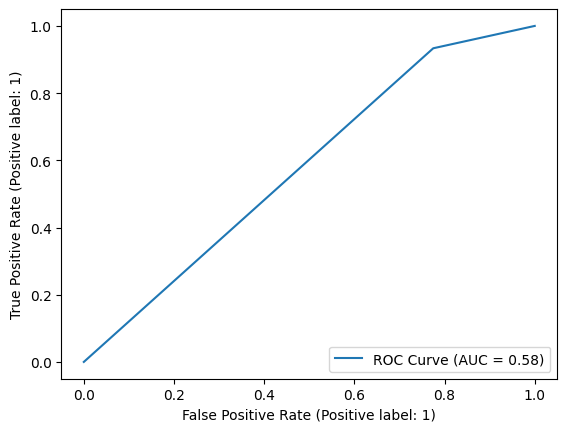

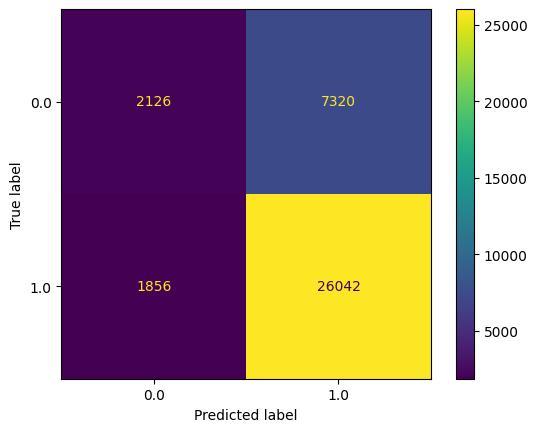

Decision Tree


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['col_2', 'col_4', 'col_5',
                                                   'col_6', 'col_7', 'col_8',
                                                   'col_9', 'col_10', 'col_11',
                                                   'col_12', 'col_13']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['col_1', 'col_3'])])),
                ('classifier', DecisionTreeClassifier())])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
val. score: 0.76427791359222
best params:  {'classifier__splitter': 'best', 'classifier__min_samples_split': 50, 'classifier__min_samples_leaf': 20, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__criterion': 'entropy'}
              precision    recall  f1-score   support

         0.0       0.52      0.26      0.35      9446
         1.0       0.79      0.92      0.85     27898

    accuracy                           0.75     37344
   macro avg       0.65      0.59      0.60     37344
weighted avg       0.72      0.75      0.72     37344



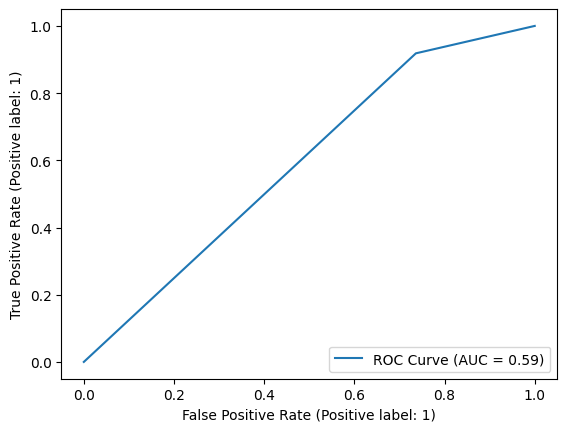

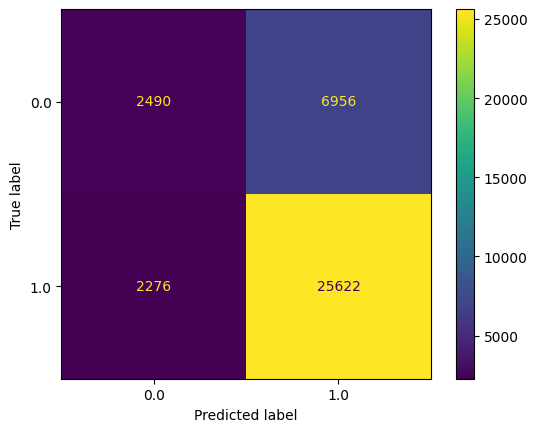

XGBoost


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['col_2', 'col_4', 'col_5',
                                                   'col_6', 'col_7', 'col_8',
                                                   'col_9', 'col_10', 'col_11',
                                                   'col_12', 'col_13']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEn...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

              precision    recall  f1-score   support

         0.0       0.57      0.30      0.39      9446
         1.0       0.80      0.92      0.85     27898

    accuracy                           0.76     37344
   macro avg       0.68      0.61      0.62     37344
weighted avg       0.74      0.76      0.74     37344



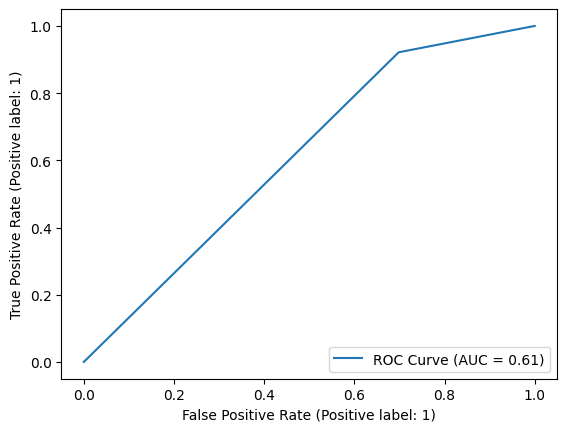

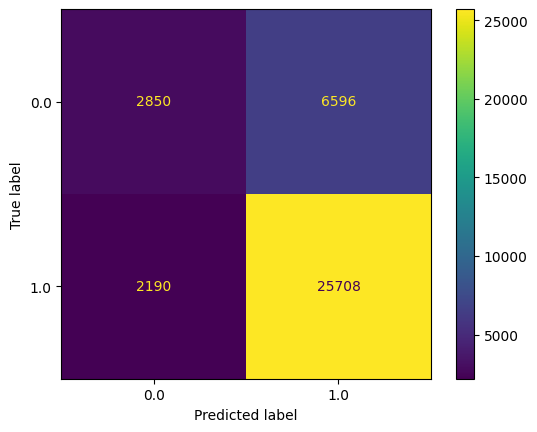

In [31]:
results = {}

# Use the train function to train the model with the hyperparameter space
for name, model in models.items():
    # Print the name of the model in big Heading and Bold font, increase the font size, use center alignment and print a line break
    print('\033[1m\033[4m\033[3m\033[34m\033[7m' + name + '\033[0m')
    results[name] = train(model, X_train, y_train, X_test, y_test, params_dict[name])

To further test more complex models, we can test a neural network model that we can build using the Keras library.

In [32]:
# Simple neural network
# Create a simple neural network with 1 hidden layers
# The second hidden layer has 50 neurons and uses the relu activation function
# The output layer has 1 neuron and uses the sigmoid activation function
# The model uses the adam optimizer and binary crossentropy as loss function
# The model is trained for 20 epochs with a batch size of 32
# The model uses the auc metric to evaluate the performance

# Import the required modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_model():
    model = Sequential([
        Dense(50, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    return model

# Create the model
model = create_model()

# Display the model
display(model)

# For neural networks, make a train-validation-test split and scale the data aswell.

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Split the train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

# Scale the data, utilize the scaler fitted on the train data on the validation and test data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
1868/1868 [==============================] - 6s 3ms/step - loss: 0.4754 - auc: 0.7681 - val_loss: 0.4660 - val_auc: 0.7808
Epoch 2/15
1868/1868 [==============================] - 4s 2ms/step - loss: 0.4647 - auc: 0.7813 - val_loss: 0.4636 - val_auc: 0.7840
Epoch 3/15
1868/1868 [==============================] - 5s 3ms/step - loss: 0.4623 - auc: 0.7840 - val_loss: 0.4615 - val_auc: 0.7849
Epoch 4/15
1868/1868 [==============================] - 4s 2ms/step - loss: 0.4609 - auc: 0.7856 - val_loss: 0.4608 - val_auc: 0.7855
Epoch 5/15
1868/1868 [==============================] - 4s 2ms/step - loss: 0.4596 - auc: 0.7871 - val_loss: 0.4604 - val_auc: 0.7867
Epoch 6/15
1868/1868 [==============================] - 5s 3ms/step - loss: 0.4584 - auc: 0.7883 - val_loss: 0.4592 - val_auc: 0.7880
Epoch 7/15
1868/1868 [==============================] - 4s 2ms/step - loss: 0.4575 - auc: 0.7892 - val_loss: 0.4581 - val_auc: 0.7881
Epoch 8/15
1868/1868 [==============================] - 4s 2ms

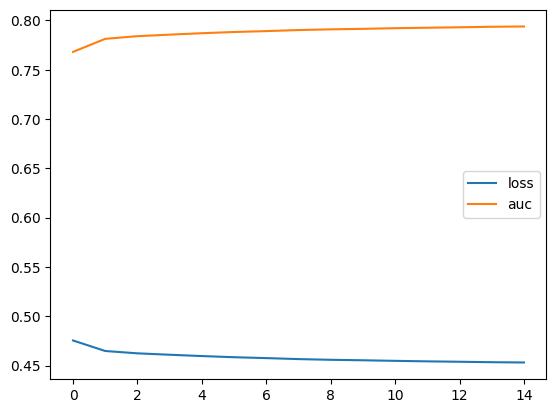

1167/1167 [==============================] - 2s 1ms/step


In [33]:
# Plot the loss and auc of the model
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['auc'], label='auc')
plt.legend()
plt.show()

# Evaluate the model
model.evaluate(X_test, y_test)

predictions = model.predict(X_test)

plt.show()

results['Neural Network'] = roc_auc_score(y_test, predictions)

Advanced techniques to tune the neural network model can be used. These include:
- Hyperparamaters: Batch size, hidden layer size, learning rate, number of epochs
- Batch Normalization
- Dropout
- Learning Rate Scheduling
- Early Stopping

Additionally, it makes more sense to split the data in train-valid-test split that can be considered.

SHAP (SHapley Additive exPlanations) can be used to explain the predictions made by the model and to understand the importance of the features in the model.
Incase it is necessary, SHAP can be used to tackle Model Bias, Model Fairness and Model Explainability.
It also aides in providing insights into Regulatory Compliance and Trust and Transparency.

# 6. Results

In [34]:
results

{'Logistic Regression': 0.5792703728337859,
 'Decision Tree': 0.5910103662920034,
 'XGBoost': 0.6116073803655484,
 'Neural Network': 0.7942101157437698}

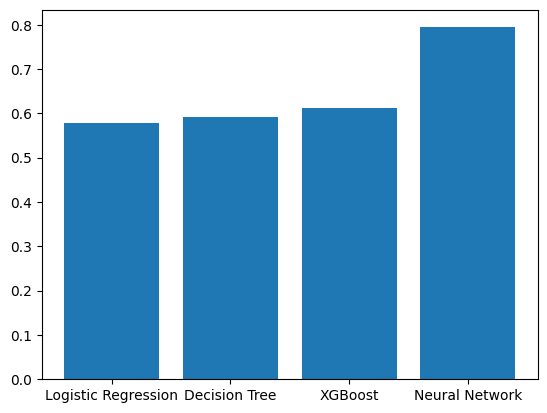

In [35]:
plt.bar(results.keys(), results.values())
plt.show()

Based on the results, the best model is selected based on ROC-AUC score (This can differ if the buisness problem is known). 
As per these findings, the best model is the Neural Network.
In our analysis of the performance, the model achieved a ROC-AUC score of 0.7896. This score signifies that the model has a strong ability to classify correctly between the classes. It means that there is approximately 78.96% chance that the model will be able to distinguish between a randomly chosen positive instance and a negative one. Though this is quite robust, there is room for improvement as an ideal model would achieve a ROC-AUC score of 1.0. Nonetheless, depending on the application and context, this level of performance might be considered highly satisfactory. with a ROC-AUC score of 0.7896

(Due to compute restrictions, I was not able to calculate the values of all models, but essentially I would choose the best model from all. Although in production, it could be much more complex as these metrics dont always translate perfectly to the desired KPIs.)

The best model is then saved to one of the following formats based on the requirements and constraints:
- Pickle
- ONNX
- PMML
- H5

The selected model can also be trained with the entire dataset before being deployed to production.

These models can be dockerized and deployed on the cloud. The service can be consumed using a REST API. The API can be built using Flask or FastAPI. Additionally, MLOps can be used to automate the deployment process.

# 7. Conclusions

 Let's consider LinkedIn's recommendation engine, which suggests people you may know, job postings that might interest you, and other content tailored to you.

In this context, a classification model might be used to predict whether a job posting would be of interest to a specific user. The positive class could be "user clicks on the job posting", and the negative class could be "user does not click on the job posting".

The ROC-AUC score is like a performance report for this recommendation model. It tells us how accurately the model distinguishes between postings that users will click and those they will not. A perfect model would score 1.0, meaning it correctly identifies all job postings that a user will click or ignore.

Our current model has a ROC-AUC score of 0.7896. This means that it has a fairly strong ability to predict correctly - approximately 79 out of 100 times, it will accurately differentiate between a job a user will click on versus one they won't. This is significantly better than random guessing, which would equate to a score of 0.5, but there's still room for improvement.

In practical terms, this model could help enhance user experience by providing them with more relevant job recommendations. Yet, we will continue refining our model to further improve its accuracy and the value it delivers to our users.